Using the following dataset : http://archive.ics.uci.edu/dataset/19/car+evaluation

In [1]:
# Import required libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
  
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
data = pd.read_csv(url, names=columns)
data.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [2]:
encoded = pd.get_dummies(data, columns=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])

X = encoded.drop("class", axis=1)
y = encoded["class"]

In [3]:
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y = y.map(label_mapping)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

1. Apply XGBoost classifier on the dataset using the following parameter : Objective = Multi Softmax , print out the classification report

In [5]:
# XGBoost Classifier

xgboost_model = XGBClassifier(objective='multi:softmax')
xgboost_model.fit(X_train, y_train)

xgboost_pred = xgboost_model.predict(X_test)

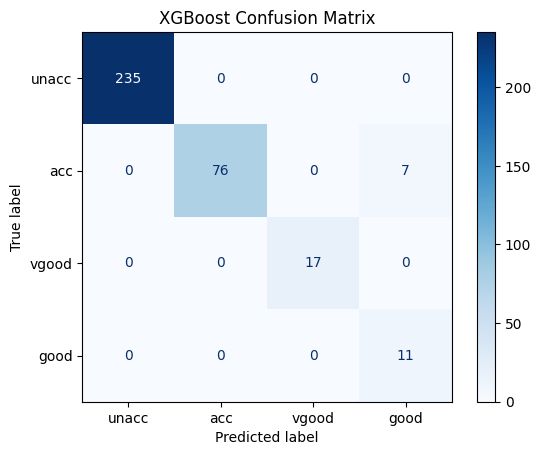

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       235
           1       1.00      0.92      0.96        83
           2       1.00      1.00      1.00        17
           3       0.61      1.00      0.76        11

    accuracy                           0.98       346
   macro avg       0.90      0.98      0.93       346
weighted avg       0.99      0.98      0.98       346



In [6]:
# XGBoost Performance Metrics
xgb_cm = confusion_matrix(y_test, xgboost_pred)
fp = confusion_matrix(y_test, xgboost_pred).ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=label_mapping.keys())
disp.plot(cmap="Blues", values_format="d")
plt.title('XGBoost Confusion Matrix')
plt.show()


classification_xgboost = classification_report(y_test, xgboost_pred)
print("Classification Report (XGBoost):")
print(classification_xgboost)

2. Apply Catboost classifier on the dataset using the following parameter : Iterations = 150 , depth = 5, learning_rate = 0.3 , loss_function='MultiClass' 

2. Also set the verbose for the Catboost model fit to 15

In [7]:
# CatBoost Classifier

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

catboost_model = CatBoostClassifier(iterations=150, depth=5, learning_rate=0.3, loss_function='MultiClass')
catboost_model.fit(train_pool, eval_set=test_pool, verbose=15)

catboost_pred = catboost_model.predict(X_test)

0:	learn: 0.9474975	test: 0.9478685	best: 0.9478685 (0)	total: 137ms	remaining: 20.5s
15:	learn: 0.2026547	test: 0.2308229	best: 0.2308229 (15)	total: 163ms	remaining: 1.36s
30:	learn: 0.1136741	test: 0.1544706	best: 0.1544706 (30)	total: 187ms	remaining: 718ms
45:	learn: 0.0760837	test: 0.1270028	best: 0.1270028 (45)	total: 212ms	remaining: 479ms
60:	learn: 0.0548474	test: 0.1110223	best: 0.1110223 (60)	total: 237ms	remaining: 345ms
75:	learn: 0.0425822	test: 0.1008521	best: 0.1008521 (75)	total: 261ms	remaining: 254ms
90:	learn: 0.0346446	test: 0.0923433	best: 0.0923433 (90)	total: 287ms	remaining: 186ms
105:	learn: 0.0287692	test: 0.0891988	best: 0.0887082 (104)	total: 311ms	remaining: 129ms
120:	learn: 0.0247338	test: 0.0888418	best: 0.0883857 (118)	total: 336ms	remaining: 80.6ms
135:	learn: 0.0219709	test: 0.0882180	best: 0.0882180 (135)	total: 362ms	remaining: 37.3ms
149:	learn: 0.0195640	test: 0.0864392	best: 0.0864392 (149)	total: 385ms	remaining: 0us

bestTest = 0.08643915502


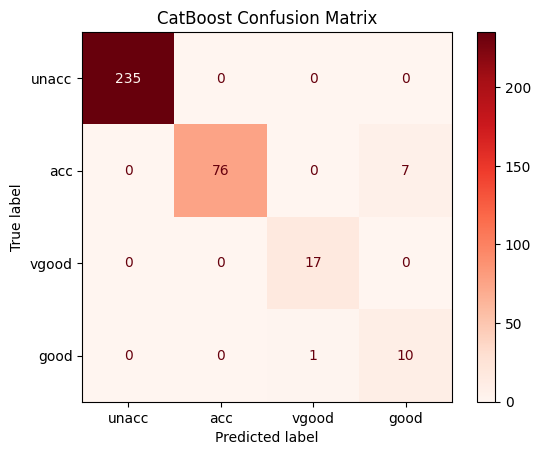

Classification Report (CatBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       235
           1       1.00      0.92      0.96        83
           2       0.94      1.00      0.97        17
           3       0.59      0.91      0.71        11

    accuracy                           0.98       346
   macro avg       0.88      0.96      0.91       346
weighted avg       0.98      0.98      0.98       346



In [8]:
# CatBoost Performance Metrics

cat_cm = confusion_matrix(y_test, catboost_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cat_cm, display_labels=label_mapping.keys())
disp.plot(cmap="Reds", values_format="d")
plt.title('CatBoost Confusion Matrix')
plt.show()


classification_catboost = classification_report(y_test, catboost_pred)
print("Classification Report (CatBoost):")
print(classification_catboost)

3. Compare the Overall Accuracy and the individual accuracy ratings between the two classifiers 

In [9]:
# Accuracy Scores

accuracy_xgb = accuracy_score(y_test, xgboost_pred)
accuracy_cat = accuracy_score(y_test, catboost_pred)
print(f"Overall Accuracy (XGBoost) : {accuracy_xgb * 100:.2f}%")
print(f"Overall Accuracy (CatBoost) : {accuracy_cat * 100:.2f}%")

Overall Accuracy (XGBoost) : 97.98%
Overall Accuracy (CatBoost) : 97.69%
